In [376]:
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')  # oder 'Qt5Agg', je nachdem, was installiert ist
%matplotlib inline
import matplotlib.pyplot as plt

tracking_data = pd.read_pickle('tracking_data.pkl')
tracking_data_full = pd.read_pickle('tracking_data_full.pkl')
tracking = pd.read_pickle('tracking.pkl')

In [377]:
import pandas as pd

ballbesitz = tracking[tracking['POSSESSION_TRACKABLE_OBJECT'].notna()]

spieler_team_df = ballbesitz[['POSSESSION_TRACKABLE_OBJECT', 'POSSESSION_GROUP']].drop_duplicates()

spieler_team_map = spieler_team_df.groupby('POSSESSION_TRACKABLE_OBJECT')['POSSESSION_GROUP'].agg(lambda x: x.mode())
away_team_ids = spieler_team_map[spieler_team_map == "away team"].index.tolist()
home_team_ids = spieler_team_map[spieler_team_map == "home team"].index.tolist()

In [378]:
tracking_ball = tracking_data_full[tracking_data_full['TRACK_ID'] == 55].copy()
tracking_ball

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,TIMESTAMP,TIME_DELTA
2,105690,60,55,55,True,0.38,-1.03,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
24,105690,61,55,55,True,0.23,-1.64,1.0,NaN,<NA>,00:00:00.1,0 days 00:00:00.100000
47,105690,62,55,55,True,-1.12,-2.63,1.0,NaN,<NA>,00:00:00.2,0 days 00:00:00.200000
76,105690,63,55,55,False,-2.49,-3.08,1.0,NaN,<NA>,00:00:00.3,0 days 00:00:00.300000
93,105690,64,55,55,False,-2.71,-3.35,1.0,NaN,<NA>,00:00:00.4,0 days 00:00:00.400000
...,...,...,...,...,...,...,...,...,...,...,...,...
1108534,105690,57448,55,55,False,-31.62,-5.59,2.0,home team,<NA>,01:34:35.8,0 days 01:34:35.800000
1108559,105690,57449,55,55,False,-30.79,-4.73,2.0,home team,<NA>,01:34:35.9,0 days 01:34:35.900000
1108580,105690,57450,55,55,False,-29.94,-3.75,2.0,home team,<NA>,01:34:36,0 days 01:34:36
1108604,105690,57451,55,55,False,-29.56,-2.92,2.0,home team,<NA>,01:34:36.1,0 days 01:34:36.100000


Der Ball fliegt gerade wenn die Geschwindikeit hoch ist und die Richtung des Balls sich nicht stark ändert.

In [379]:
tracking_ball['ball_in_game'] = tracking_ball['TIME_DELTA'].diff() <= "00:00:00.1"

In [380]:
tracking_ball['dX'] = tracking_ball['X'].diff()
tracking_ball['dY'] = tracking_ball['Y'].diff()

In [381]:
tracking_ball['speed'] = np.sqrt(tracking_ball['dX']**2 + tracking_ball['dY']**2)

In [382]:
tracking_ball['angle'] = np.degrees(np.arctan2(tracking_ball['dY'], tracking_ball['dX']))
tracking_ball['angle_change'] = tracking_ball['angle'].diff()

tracking_ball['angle_shifted_2'] = tracking_ball['angle'].shift(-2)

tracking_ball['angle_diff_2frames'] = tracking_ball['angle_shifted_2'] - tracking_ball['angle']

In [383]:
tracking_ball['ball_in_motion'] = (tracking_ball['speed'] >= 0.5) & (tracking_ball['angle_change'] <=10) & (tracking_ball['ball_in_game']) & (tracking_ball['angle_diff_2frames'] <=10)

Bei einem Pass muss der Ball mindestens 5 Frames hintereinander in Bewegung sein. Filtere also nur diejenigen Frames bei denen ball_in_motion jeweils 5mal hintereinander True ist

In [384]:
tracking_ball['motion_number'] = (tracking_ball['ball_in_motion'] != tracking_ball['ball_in_motion'].shift()).cumsum()

group_sizes = tracking_ball.groupby('motion_number')['ball_in_motion'].transform('sum')

tracking_ball['pass'] = (tracking_ball['ball_in_motion']) & (group_sizes >= 8)

Problematisch bisher: Kurze Pässe und lange Dribblings mit Ball geradeaus.

In [385]:
tracking_ball

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,...,dX,dY,speed,angle,angle_change,angle_shifted_2,angle_diff_2frames,ball_in_motion,motion_number,pass
2,105690,60,55,55,True,0.38,-1.03,1.0,NaN,<NA>,...,NaN,NaN,NaN,NaN,NaN,-143.746162,NaN,False,1,False
24,105690,61,55,55,True,0.23,-1.64,1.0,NaN,<NA>,...,-0.15,-0.61,0.628172,-103.815025,NaN,-161.816347,-58.001322,False,1,False
47,105690,62,55,55,True,-1.12,-2.63,1.0,NaN,<NA>,...,-1.35,-0.99,1.674097,-143.746162,-39.931137,-129.173658,14.572504,False,1,False
76,105690,63,55,55,False,-2.49,-3.08,1.0,NaN,<NA>,...,-1.37,-0.45,1.442012,-161.816347,-18.070185,-128.157227,33.659120,False,1,False
93,105690,64,55,55,False,-2.71,-3.35,1.0,NaN,<NA>,...,-0.22,-0.27,0.348281,-129.173658,32.642689,-122.660913,6.512745,False,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108534,105690,57448,55,55,False,-31.62,-5.59,2.0,home team,<NA>,...,0.68,0.75,1.012373,47.802452,2.802452,49.063366,1.260914,True,4206,False
1108559,105690,57449,55,55,False,-30.79,-4.73,2.0,home team,<NA>,...,0.83,0.86,1.195199,46.016978,-1.785473,65.400209,19.383231,False,4207,False
1108580,105690,57450,55,55,False,-29.94,-3.75,2.0,home team,<NA>,...,0.85,0.98,1.297266,49.063366,3.046388,38.027231,-11.036135,True,4208,False
1108604,105690,57451,55,55,False,-29.56,-2.92,2.0,home team,<NA>,...,0.38,0.83,0.912853,65.400209,16.336843,NaN,NaN,False,4209,False


In [386]:
passes = tracking_ball[tracking_ball['pass'] == True].copy()

Nummeriere Pässe durch

In [387]:
unique_motions = passes['motion_number'].dropna().unique()
motion_map = {old: new for new, old in enumerate(sorted(unique_motions), start=1)}

passes['motion_number'] = passes['motion_number'].map(motion_map)

In [388]:
passes

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,...,dX,dY,speed,angle,angle_change,angle_shifted_2,angle_diff_2frames,ball_in_motion,motion_number,pass
829,105690,96,55,55,True,-1.23,2.40,1.0,away team,28566,...,-0.64,0.56,0.850412,138.814075,8.387996,147.414293,8.600218,True,1,True
852,105690,97,55,55,True,-2.04,3.00,1.0,away team,<NA>,...,-0.81,0.60,1.008018,143.471145,4.657070,150.668160,7.197016,True,1,True
875,105690,98,55,55,True,-3.01,3.62,1.0,away team,<NA>,...,-0.97,0.62,1.151217,147.414293,3.943148,150.615843,3.201550,True,1,True
898,105690,99,55,55,True,-4.06,4.21,1.0,away team,<NA>,...,-1.05,0.59,1.204409,150.668160,3.253868,150.054317,-0.613844,True,1,True
921,105690,100,55,55,True,-5.09,4.79,1.0,away team,<NA>,...,-1.03,0.58,1.182074,150.615843,-0.052318,149.905759,-0.710084,True,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107321,105690,57395,55,55,False,-39.08,-12.27,2.0,away team,<NA>,...,-0.69,0.71,0.990051,134.181545,1.945402,132.552951,-1.628593,True,866,True
1107339,105690,57396,55,55,False,-39.70,-11.62,2.0,away team,<NA>,...,-0.62,0.65,0.898276,133.646808,-0.534736,132.108730,-1.538078,True,866,True
1107362,105690,57397,55,55,False,-40.26,-11.01,2.0,away team,<NA>,...,-0.56,0.61,0.828070,132.552951,-1.093857,129.143986,-3.408965,True,866,True
1107390,105690,57398,55,55,False,-40.73,-10.49,2.0,away team,<NA>,...,-0.47,0.52,0.700928,132.108730,-0.444221,127.746805,-4.361925,True,866,True


In [389]:
len(passes['motion_number'].unique())

866

In [390]:
passes_home_first_half = passes[(passes['PERIOD'] == 2.0) & (passes['POSSESSION_GROUP'] == 'home team')]

In [391]:
pass_numbers = passes_home_first_half['motion_number'].unique()

In [392]:
len(pass_numbers)

216

In [393]:
# Funktion zur Extraktion eines Passes als eine Zeile
def extract_pass_info(group):
    start = group.iloc[0]
    end = group.iloc[-1]
    
    return pd.Series({
        'motion_number': start['motion_number'],
        'start_X': start['X'],
        'start_Y': start['Y'],
        'end_X': end['X'],
        'end_Y': end['Y'],
        'PERIOD': start['PERIOD'],
        'POSSESSION_GROUP_start': start['POSSESSION_GROUP'],
        'POSSESSION_GROUP_end': end['POSSESSION_GROUP'],
        'FRAME_START': start['FRAME'],
        'FRAME_END': end['FRAME'],
        'POSSESSION_TRACKABLE_OBJECT': start['POSSESSION_TRACKABLE_OBJECT'],
        'Angekommen': start['POSSESSION_GROUP'] == end['POSSESSION_GROUP']
    })

# Nach motion_number gruppieren und pro Pass zusammenfassen
passes_summary = passes.groupby('motion_number').apply(extract_pass_info).reset_index(drop=True)

In [394]:
passes_summary

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen
0,1,-1.23,2.40,-13.96,11.76,1.0,away team,away team,96,114,28566,True
1,2,-13.84,12.75,-3.90,28.36,1.0,away team,away team,116,131,24372,True
2,3,0.32,31.75,-8.89,29.12,1.0,home team,home team,174,188,<NA>,True
3,4,-6.60,24.64,7.12,25.91,1.0,away team,away team,233,240,<NA>,True
4,5,8.95,31.28,17.63,24.20,1.0,away team,home team,259,267,<NA>,False
...,...,...,...,...,...,...,...,...,...,...,...,...
861,862,-0.53,-19.75,3.27,-20.59,2.0,away team,away team,57105,57112,<NA>,True
862,863,6.68,-20.79,-7.24,-28.90,2.0,away team,away team,57136,57153,<NA>,True
863,864,-26.85,-21.97,-32.17,-1.23,2.0,away team,away team,57325,57349,<NA>,True
864,865,-32.55,0.98,-20.84,-28.49,2.0,away team,away team,57355,57368,<NA>,True


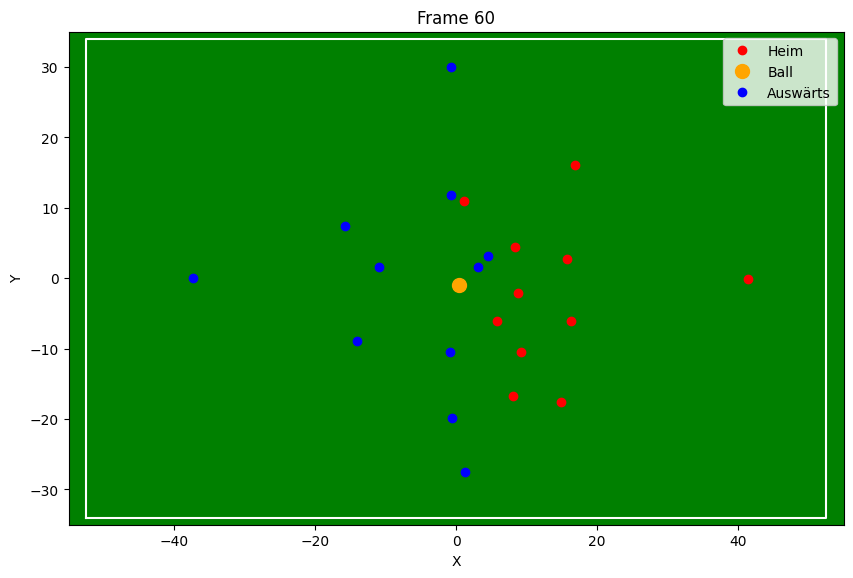

In [395]:
import matplotlib.pyplot as plt

def plot_spieler(tracking_df, frame, pass_number=None, team0_ids=away_team_ids, team1_ids=home_team_ids, ball_id=55, ax=None, plot_pass_area = False):
    df = tracking_df[tracking_df['FRAME'] == frame]

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 7))
    
    ax.clear()  # WICHTIG für Animation!
    ax.set_facecolor('green')
    ax.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")

    ax.set_xlim(-55, 55)
    ax.set_ylim(-35, 35)
    ax.set_aspect('equal')

    ball_plotted = team0_plotted = team1_plotted = False

    for _, row in df.iterrows():
        if row['TRACK_ID'] == ball_id:
            ax.plot(row['X'], row['Y'], 'o', color='orange', markersize=10, label='Ball' if not ball_plotted else "")
            ball_plotted = True
        elif team0_ids and row['TRACK_ID'] in team0_ids:
            ax.plot(row['X'], row['Y'], 'o', color='blue', label='Auswärts' if not team0_plotted else "")
            team0_plotted = True
        elif team1_ids and row['TRACK_ID'] in team1_ids:
            ax.plot(row['X'], row['Y'], 'o', color='red', label='Heim' if not team1_plotted else "")
            team1_plotted = True
        else:
            ax.plot(row['X'], row['Y'], 'o', color='gray')

    if pass_number is not None:
        pass_to_plot = passes_summary[passes_summary['motion_number'] == pass_number]
        if not pass_to_plot.empty:
            dx = pass_to_plot['end_X'].values[0] - pass_to_plot['start_X'].values[0]
            dy = pass_to_plot['end_Y'].values[0] - pass_to_plot['start_Y'].values[0]
            ax.quiver(
                pass_to_plot['start_X'], pass_to_plot['start_Y'],
                dx, dy,
                angles='xy',
                scale_units='xy',
                scale=1,
                color='blue',
                width=0.003,
                headwidth=3,
                headlength=5)
        if plot_pass_area:
            x = [pass_to_plot['start_X'], pass_to_plot['start_X'], pass_to_plot['end_X'], pass_to_plot['end_X']]
            if pass_to_plot['start_Y'].values[0] < pass_to_plot['end_Y'].values[0]:
                y = [pass_to_plot['start_Y']-4, pass_to_plot['end_Y']+4, pass_to_plot['end_Y']+4, pass_to_plot['start_Y']-4]
            else:
                y = [pass_to_plot['start_Y']+4, pass_to_plot['end_Y']-4, pass_to_plot['end_Y']-4, pass_to_plot['start_Y']+4]
            ax.fill(x, y, color='yellow', alpha=0.3, hatch='//')

    ax.set_title(f"Frame {frame}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend(loc='upper right')

plot_spieler(tracking_data, 60)

Als Nächtes möchte ich den Passgeber und Passempfänger identifizieren. Leider hat die Spalte 'POSSESSION_TRACKABLE_OBJECT' fehlende Werte. Daher nehme ich den nächsten Spieler zum Ball. Falls eine Ballbesitzmannschaft bekannt ist, nehme ich den nächsten Spieler zum Ball aus dieser Mannschaft.

In [396]:
def get_closest_player(frame, possession_group ,ball_id=55):

    #if POSSESSION_GROUP is known we search the clsoest player of this team

    frame_data = tracking_data[tracking_data['FRAME'] == frame]
    ball_pos = frame_data[frame_data['TRACK_ID'] == ball_id][['X', 'Y']]

    ball_x, ball_y = ball_pos.iloc[0]['X'], ball_pos.iloc[0]['Y']

    if possession_group == 'home team':
        players = frame_data[(frame_data['TRACK_ID'] != ball_id) & (frame_data['TRACK_ID'].isin(home_team_ids))][['TRACK_ID', 'X', 'Y']].copy()
    elif possession_group == "away team":
        players = frame_data[(frame_data['TRACK_ID'] != ball_id) & (frame_data['TRACK_ID'].isin(away_team_ids))][['TRACK_ID', 'X', 'Y']].copy()
    else:
        players = frame_data[(frame_data['TRACK_ID'] != ball_id)][['TRACK_ID', 'X', 'Y']].copy()


    players['distance_to_ball'] = ((players['X'] - ball_x)**2 + (players['Y'] - ball_y)**2)**0.5

    closest_player_id = players.loc[players['distance_to_ball'].idxmin()] ['TRACK_ID']

    return closest_player_id

get_closest_player(96, None)

28566.0

In [397]:
passes_summary['Passgeber'] = passes_summary.apply(
    lambda row: get_closest_player(row['FRAME_START'], row['POSSESSION_GROUP_start']),
    axis=1
)
passes_summary['Passempfänger'] = passes_summary.apply(
    lambda row: get_closest_player(row['FRAME_END'], row['POSSESSION_GROUP_end']),
    axis=1
)

Visualisiere Pässe von einem Spieler

In [398]:
motion_numbers = passes_summary[(passes_summary['POSSESSION_GROUP_end'] == 'away team') & (passes_summary['PERIOD'] == 2)]['motion_number']

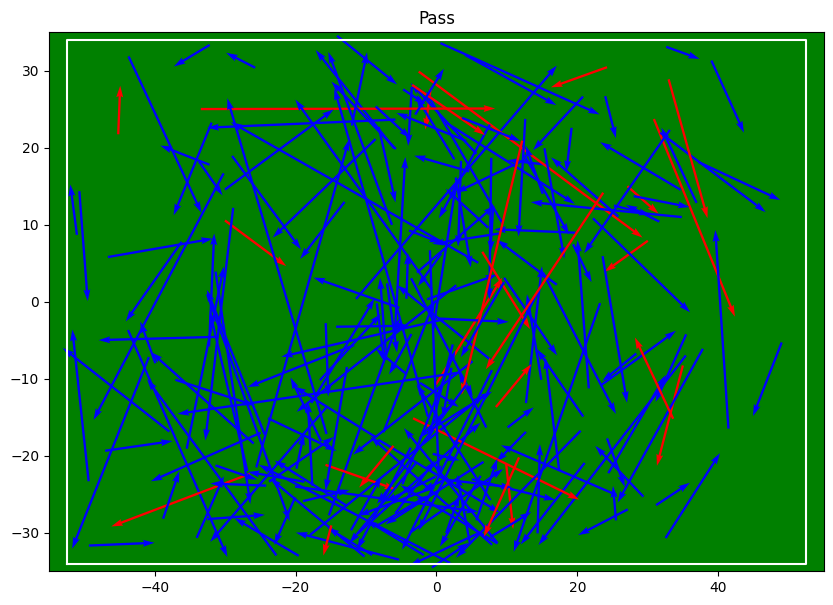

In [399]:
def visualize_passes(passes_summary, motion_numbers, show_player = False):
    pass_sequence = passes_summary[passes_summary['motion_number'].isin(motion_numbers)]
    
    plt.figure(figsize=(10, 7))
    plt.title("Pass")

    plt.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")
    plt.gca().set_facecolor("green")
    plt.xlim(-55, 55)
    plt.ylim(-35, 35)

    for _, row in pass_sequence.iterrows():
        color = 'blue' if row['Angekommen'] else 'red'
        dx = row['end_X'] - row['start_X']
        dy = row['end_Y'] - row['start_Y']

        plt.quiver(
            row['start_X'], row['start_Y'],  # Startpunkt
            dx, dy,                          # Richtungsvektor
            angles='xy',
            scale_units='xy',
            scale=1,
            color=color,
            width=0.003,
            headwidth=3,
            headlength=5
        )        

    plt.show()

visualize_passes(passes_summary, motion_numbers)


In [400]:
passes_summary

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen,Passgeber,Passempfänger
0,1,-1.23,2.40,-13.96,11.76,1.0,away team,away team,96,114,28566,True,28566.0,24372.0
1,2,-13.84,12.75,-3.90,28.36,1.0,away team,away team,116,131,24372,True,24372.0,39023.0
2,3,0.32,31.75,-8.89,29.12,1.0,home team,home team,174,188,<NA>,True,16427.0,16471.0
3,4,-6.60,24.64,7.12,25.91,1.0,away team,away team,233,240,<NA>,True,24372.0,28566.0
4,5,8.95,31.28,17.63,24.20,1.0,away team,home team,259,267,<NA>,False,39023.0,39015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,862,-0.53,-19.75,3.27,-20.59,2.0,away team,away team,57105,57112,<NA>,True,39023.0,39023.0
862,863,6.68,-20.79,-7.24,-28.90,2.0,away team,away team,57136,57153,<NA>,True,39023.0,39023.0
863,864,-26.85,-21.97,-32.17,-1.23,2.0,away team,away team,57325,57349,<NA>,True,14926.0,29957.0
864,865,-32.55,0.98,-20.84,-28.49,2.0,away team,away team,57355,57368,<NA>,True,29957.0,39023.0


## Überspielte Verteidiger

Ein Gegner gilt dann als überspielt wenn er in der folgenden Range liegt.

In [401]:
passes_summary[passes_summary['motion_number'] == 309]

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen,Passgeber,Passempfänger
308,309,36.55,-4.72,54.68,9.0,1.0,home team,home team,18944,18961,<NA>,True,28540.0,29938.0


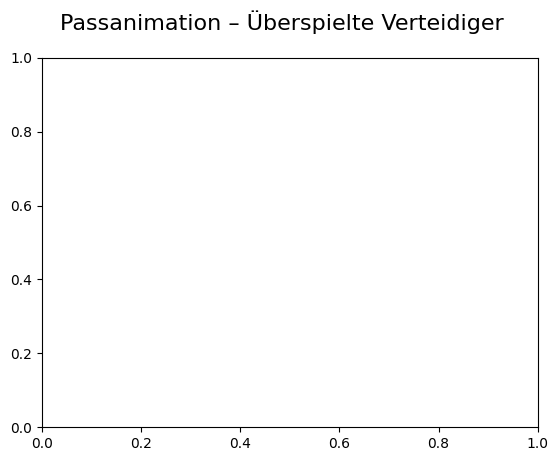

In [402]:
pass_num = 556
frames = list(range(passes_summary[passes_summary['motion_number'] == pass_num]['FRAME_START'].iloc[0], passes_summary[passes_summary['motion_number'] == pass_num]['FRAME_END'].iloc[0]))  # oder eine andere Frame-Range


from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.suptitle("Passanimation – Überspielte Verteidiger", fontsize=16)


# Beispielanimation
def update(frame):
    ax.clear()
    plot_spieler(tracking_data, frame, pass_number=pass_num, ax = ax, plot_pass_area=True)
    return ax,

ani = FuncAnimation(fig, update, frames=frames, interval=400)

plt.show()

In [403]:
ani.save("pass_animation.gif", writer='pillow')

In [404]:
def überspielte_verteidiger(start_frame, end_frame, possession_group, period, passgeber):

    start_data = tracking_data[tracking_data['FRAME'] == start_frame]
    end_data = tracking_data[tracking_data['FRAME'] == end_frame]
    
    ball_start = start_data[start_data['TRACK_ID'] == 55][['X', 'Y']].iloc[0]
    ball_end = end_data[end_data['TRACK_ID'] == 55][['X', 'Y']].iloc[0]

    
    if passgeber in home_team_ids:
        gegner_ids = away_team_ids
    elif passgeber in away_team_ids :
        gegner_ids = home_team_ids

    gegner_start = start_data[start_data['TRACK_ID'].isin(gegner_ids)][['TRACK_ID', 'X', 'Y']].copy()
    gegner_end = end_data[end_data['TRACK_ID'].isin(gegner_ids)][['TRACK_ID', 'X', 'Y']].copy()


    def zwischen_ball_und_tor(row, team, ball_pos):
        if (team == 'away team' and period == 1) or (team == 'home team' and period == 2):
            return row['X'] > ball_pos['X']  # Richtung rechtes Tor
        else:
            return row['X'] < ball_pos['X']  # Richtung linkes Tor

    gegner_start['zwischen'] = gegner_start.apply(lambda row: zwischen_ball_und_tor(row, possession_group, ball_start), axis=1)
    gegner_end['zwischen'] = gegner_end.apply(lambda row: zwischen_ball_und_tor(row, possession_group, ball_end), axis=1)
    
    y_min = min(ball_start['Y'], ball_end['Y']) - 4
    y_max = max(ball_start['Y'], ball_end['Y']) + 4

    # IDs der Gegner, die am Ende im Y-Korridor sind
    gegner_end_ids_in_y_corridor = gegner_end[(gegner_end['Y'] >= y_min) & (gegner_end['Y'] <= y_max)]['TRACK_ID']

    # Filter auf gegner_start anwenden
    überspielt = gegner_start[
        (gegner_start['zwischen']) &
        (~gegner_start['TRACK_ID'].isin(gegner_end[gegner_end['zwischen']]['TRACK_ID'])) &
        (gegner_start['Y'] >= y_min) & (gegner_start['Y'] <= y_max) &
        (gegner_start['TRACK_ID'].isin(gegner_end_ids_in_y_corridor))
    ]

    return len(überspielt)


In [405]:
passes_summary['überspielte Verteidiger'] = passes_summary.apply(
    lambda row: überspielte_verteidiger(row['FRAME_START'], row['FRAME_END'], row['POSSESSION_GROUP_start'], row['PERIOD'], row['Passgeber']),
    axis=1
)

In [406]:
passes_summary

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen,Passgeber,Passempfänger,überspielte Verteidiger
0,1,-1.23,2.40,-13.96,11.76,1.0,away team,away team,96,114,28566,True,28566.0,24372.0,0
1,2,-13.84,12.75,-3.90,28.36,1.0,away team,away team,116,131,24372,True,24372.0,39023.0,1
2,3,0.32,31.75,-8.89,29.12,1.0,home team,home team,174,188,<NA>,True,16427.0,16471.0,0
3,4,-6.60,24.64,7.12,25.91,1.0,away team,away team,233,240,<NA>,True,24372.0,28566.0,1
4,5,8.95,31.28,17.63,24.20,1.0,away team,home team,259,267,<NA>,False,39023.0,39015.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,862,-0.53,-19.75,3.27,-20.59,2.0,away team,away team,57105,57112,<NA>,True,39023.0,39023.0,0
862,863,6.68,-20.79,-7.24,-28.90,2.0,away team,away team,57136,57153,<NA>,True,39023.0,39023.0,1
863,864,-26.85,-21.97,-32.17,-1.23,2.0,away team,away team,57325,57349,<NA>,True,14926.0,29957.0,1
864,865,-32.55,0.98,-20.84,-28.49,2.0,away team,away team,57355,57368,<NA>,True,29957.0,39023.0,0


In [407]:
player_summary = pd.DataFrame()
player_summary['Player'] = tracking_data[tracking_data['TRACK_ID'] != 55]['TRACK_ID'].unique()

In [408]:
player_summary['team'] = player_summary['Player'].apply(lambda x : 'home team' if x in home_team_ids else 'away_team')

In [409]:
passes_summary['überspielte Verteidiger'].unique()

array([0, 1, 2, 4, 6, 7, 3, 8, 5], dtype=int64)

In [410]:
player_summary['Pässe'] = player_summary['Player'].apply(lambda x: len(passes_summary[passes_summary['Passgeber'] == x]))
player_summary['Angekommene Pässe'] = player_summary['Player'].apply(lambda x: len(passes_summary[(passes_summary['Passgeber'] == x) & (passes_summary['Angekommen'])]))
player_summary['Fehlpässe'] = player_summary['Player'].apply(lambda x: len(passes_summary[(passes_summary['Passgeber'] == x) & (~passes_summary['Angekommen'])]))
player_summary['Passquote'] = player_summary['Angekommene Pässe'] / player_summary['Pässe']

player_summary['Überspielte Verteidiger'] = player_summary['Player'].apply(lambda x: sum(passes_summary[(passes_summary['Passgeber'] == x) & (passes_summary['Angekommen'])]['überspielte Verteidiger']))

Ermittle wer in der Startaufstellung war.

In [411]:
start_ids = tracking_data[tracking_data['FRAME'] == 60]['TRACK_ID'].unique()
player_summary['Startaufstellung'] = player_summary['Player'].isin(start_ids)

In [412]:
player_summary

,Player,team,Pässe,Angekommene Pässe,Fehlpässe,Passquote,Überspielte Verteidiger,Startaufstellung
0,28437,home team,31,23,8,0.741935,6,True
1,16471,home team,36,27,9,0.750000,15,True
2,28435,away_team,18,15,3,0.833333,3,True
3,28566,away_team,50,39,11,0.780000,27,True
4,29957,away_team,42,36,6,0.857143,8,True
5,29926,away_team,45,41,4,0.911111,19,True
6,61575,away_team,34,33,1,0.970588,18,True
7,28555,away_team,58,51,7,0.879310,33,True
8,39023,away_team,58,51,7,0.879310,33,True
9,28565,away_team,37,33,4,0.891892,19,True


Ermittle wann ein Spieler eingewechselt wurde. Finde also das erste Frame an dem es Daten zu dem Spieler gibt und an dem er VISIBLE ist.

In [413]:
def find_einwechslung(player_id):

    in_startelf = player_summary.loc[player_summary['Player'] == player_id, 'Startaufstellung'].iloc[0]

    if in_startelf:
        return "00:00:00"
    
    # Spieler war nicht in der Startaufstellung → finde erstes sichtbares Frame
    visible_rows = tracking_data_full[tracking_data['TRACK_ID'] == player_id]
    if visible_rows.empty:
        return None
    
    first_visible_row = visible_rows.sort_values('TIME_DELTA').iloc[0]
    return first_visible_row['TIMESTAMP']

def find_auswechslung(player_id):

    visible_rows = tracking_data_full[tracking_data['TRACK_ID'] == player_id]
    
    last_visible_row = visible_rows.sort_values('TIME_DELTA').iloc[-1]
    return last_visible_row['TIMESTAMP']

player_summary['Einwechslung'] = player_summary['Player'].apply(find_einwechslung)
player_summary['Auswechslung'] = player_summary['Player'].apply(find_auswechslung)

In [414]:
player_summary

,Player,team,Pässe,Angekommene Pässe,Fehlpässe,Passquote,Überspielte Verteidiger,Startaufstellung,Einwechslung,Auswechslung
0,28437,home team,31,23,8,0.741935,6,True,00:00:00,01:10:26.9
1,16471,home team,36,27,9,0.750000,15,True,00:00:00,01:24:39.6
2,28435,away_team,18,15,3,0.833333,3,True,00:00:00,01:34:36.2
3,28566,away_team,50,39,11,0.780000,27,True,00:00:00,01:34:36.2
4,29957,away_team,42,36,6,0.857143,8,True,00:00:00,01:34:36.2
5,29926,away_team,45,41,4,0.911111,19,True,00:00:00,01:08:32.9
6,61575,away_team,34,33,1,0.970588,18,True,00:00:00,00:54:30.1
7,28555,away_team,58,51,7,0.879310,33,True,00:00:00,01:08:32.9
8,39023,away_team,58,51,7,0.879310,33,True,00:00:00,01:34:36.2
9,28565,away_team,37,33,4,0.891892,19,True,00:00:00,01:34:36.2


## Torschüsse erkennen
Falls der Ball in der Torzone gelandet ist.

In [415]:
passes_summary

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen,Passgeber,Passempfänger,überspielte Verteidiger
0,1,-1.23,2.40,-13.96,11.76,1.0,away team,away team,96,114,28566,True,28566.0,24372.0,0
1,2,-13.84,12.75,-3.90,28.36,1.0,away team,away team,116,131,24372,True,24372.0,39023.0,1
2,3,0.32,31.75,-8.89,29.12,1.0,home team,home team,174,188,<NA>,True,16427.0,16471.0,0
3,4,-6.60,24.64,7.12,25.91,1.0,away team,away team,233,240,<NA>,True,24372.0,28566.0,1
4,5,8.95,31.28,17.63,24.20,1.0,away team,home team,259,267,<NA>,False,39023.0,39015.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,862,-0.53,-19.75,3.27,-20.59,2.0,away team,away team,57105,57112,<NA>,True,39023.0,39023.0,0
862,863,6.68,-20.79,-7.24,-28.90,2.0,away team,away team,57136,57153,<NA>,True,39023.0,39023.0,1
863,864,-26.85,-21.97,-32.17,-1.23,2.0,away team,away team,57325,57349,<NA>,True,14926.0,29957.0,1
864,865,-32.55,0.98,-20.84,-28.49,2.0,away team,away team,57355,57368,<NA>,True,29957.0,39023.0,0


In [416]:
passes_summary['Torschuss'] = ((passes_summary['end_X'] > 50) | (passes_summary['end_X'] < -50)) & (passes_summary['end_Y'].abs() < 10)

In [417]:
passes_summary[passes_summary['Torschuss']]

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen,Passgeber,Passempfänger,überspielte Verteidiger,Torschuss
78,79,51.60,-25.50,56.11,-8.46,1.0,away team,away team,4948,4960,28565,True,28565.0,29957.0,0,True
79,80,57.00,-6.44,64.06,2.50,1.0,away team,away team,4962,4973,<NA>,True,28566.0,28435.0,0,True
80,81,61.89,-1.29,57.17,-5.22,1.0,away team,NaN,4982,4991,<NA>,False,28566.0,29938.0,0,True
135,136,48.09,3.01,52.18,6.85,1.0,home team,NaN,8006,8014,<NA>,False,29938.0,28566.0,0,True
308,309,36.55,-4.72,54.68,9.00,1.0,home team,home team,18944,18961,<NA>,True,28540.0,29938.0,0,True
464,465,-37.92,-16.85,-53.05,-5.99,2.0,away team,away team,28935,28952,<NA>,True,39023.0,28555.0,5,True
479,480,43.90,23.63,50.71,8.61,2.0,home team,home team,30201,30213,<NA>,True,16471.0,16427.0,1,True
854,855,-49.37,-23.31,-51.68,-3.60,2.0,away team,away team,56700,56718,<NA>,True,28566.0,28566.0,1,True


Torschuss mit motion_number 309 wurde als Tor identifiziert für "away team". Danach folgt eine Spielunterbrechung und der Ball startet von der Mitte aus wieder. Bei allen anderen Torschüssen, geht das Spiel mit einer Ecke oder einem Abstoß weiter.

Endtand 1:0 für away_team!

In [418]:
passes_summary.to_pickle('passes.pkl')
player_summary.to_pickle('player_summary.pkl')